In [59]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from datasets import Dataset
import os, re, torch, evaluate, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from transformers import (AutoTokenizer, DataCollatorWithPadding,
                          AutoModelForSequenceClassification, TrainingArguments, Trainer)
from peft import LoraConfig, TaskType, get_peft_model


In [60]:
# ==== 1) choose local folder & subset file ====
DATA_DIR = "./" 
CANDIDATES = [
    "Sentences_AllAgree.txt",   # prefer clean labels
    "Sentences_75Agree.txt",
    "Sentences_66Agree.txt",
    "Sentences_50Agree.txt"
]
subset_path = None
for name in CANDIDATES:
    p = os.path.join(DATA_DIR, name)
    if os.path.exists(p):
        subset_path = p
        break
assert subset_path is not None, "No Sentences_*Agree.txt found in DATA_DIR."

print(f"Using subset file: {os.path.basename(subset_path)}")

# ==== 2) parse txt -> DataFrame ====
def read_finphrase_txt(path):
    rows = []
    # supports 'text @label' OR 'text\tlabel' OR 'text , label'
    pat = re.compile(r'^\s*"?(.+?)"?\s*(?:@|\t|,)\s*(positive|negative|neutral)\s*$', re.I)
    # try utf-8 first, fallback latin-1 if needed
    for enc in ("utf-8", "latin-1"):
        try:
            with open(path, "r", encoding=enc) as f:
                for line in f:
                    line = line.strip()
                    if not line: 
                        continue
                    m = pat.match(line)
                    if m:
                        rows.append({"sentence": m.group(1), "label": m.group(2).lower()})
                    else:
                        # last-token fallback split
                        parts = re.split(r'\s+', line)
                        lab = parts[-1].lower()
                        if lab in {"positive","negative","neutral"}:
                            rows.append({"sentence": " ".join(parts[:-1]), "label": lab})
            break
        except UnicodeDecodeError:
            continue
    return pd.DataFrame(rows)

df = read_finphrase_txt(subset_path).dropna().drop_duplicates()
assert len(df) > 0, "Parsed 0 rows. Check file format."

# map labels to ids
lab2id = {"negative":0, "neutral":1, "positive":2}
df["label_id"] = df["label"].map(lab2id)

# ==== 3) quick sanity checks ====
print("Total samples:", len(df))
print("Label counts:\n", df["label"].value_counts())
print("Label ratio:\n", (df["label"].value_counts(normalize=True) * 100).round(2), "%")
print("\nSample rows:")
print(df.sample(5, random_state=42)[["sentence","label"]])

# ==== 4) split to train/valid/test (stratified) ====
train_df, test_df = train_test_split(df, test_size=0.10, random_state=42, stratify=df["label_id"])
train_df, valid_df = train_test_split(train_df, test_size=0.10, random_state=42, stratify=train_df["label_id"])

print(f"\nSplits => train: {len(train_df)} | valid: {len(valid_df)} | test: {len(test_df)}")

# wrap into HF Datasets for later training
ds_train = Dataset.from_pandas(train_df[["sentence","label_id"]].rename(columns={"label_id":"label"}), preserve_index=False)
ds_valid = Dataset.from_pandas(valid_df[["sentence","label_id"]].rename(columns={"label_id":"label"}), preserve_index=False)
ds_test  = Dataset.from_pandas(test_df[ ["sentence","label_id"]].rename(columns={"label_id":"label"}), preserve_index=False)

# minimal asserts
assert set(ds_train.features.keys()) == {"sentence","label"}
assert all(v in {0,1,2} for v in ds_train["label"])
print("Datasets ready ✅")

Using subset file: Sentences_AllAgree.txt
Total samples: 2259
Label counts:
 label
neutral     1386
positive     570
negative     303
Name: count, dtype: int64
Label ratio:
 label
neutral     61.35
positive    25.23
negative    13.41
Name: proportion, dtype: float64 %

Sample rows:
                                               sentence     label
1578  - The Group -¦ s sales during the period were ...   neutral
368   Profit after taxes for the period was up to EU...  positive
529   `` They want my credit card info and my person...   neutral
1535         The value of the orders is over EUR 10mn .   neutral
56    In 2009 , Fiskars ' cash flow from operating a...  positive

Splits => train: 1829 | valid: 204 | test: 226
Datasets ready ✅


Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Map:   0%|          | 0/204 [00:00<?, ? examples/s]

Map:   0%|          | 0/226 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_230/1343806841.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.732000,0.342376,0.916667,0.857120
2,0.299300,0.147571,0.946078,0.921218
3,0.139000,0.096004,0.965686,0.947911
4,0.066100,0.084149,0.980392,0.966486
5,0.027600,0.087711,0.975490,0.956429
6,0.028000,0.121980,0.975490,0.956429
7,0.012900,0.102619,0.975490,0.957158
8,0.010200,0.131569,0.975490,0.956429
9,0.006200,0.069826,0.975490,0.957158
10,0.009900,0.119810,0.975490,0.956429


VALID => {'eval_loss': 0.08414911478757858, 'eval_accuracy': 0.9803921568627451, 'eval_f1_macro': 0.9664855192622038, 'eval_runtime': 0.2322, 'eval_samples_per_second': 878.505, 'eval_steps_per_second': 30.145, 'epoch': 20.0}
TEST  => {'eval_loss': 0.15437428653240204, 'eval_accuracy': 0.9646017699115044, 'eval_f1_macro': 0.9499583541562552, 'eval_runtime': 0.2536, 'eval_samples_per_second': 891.284, 'eval_steps_per_second': 31.55, 'epoch': 20.0}


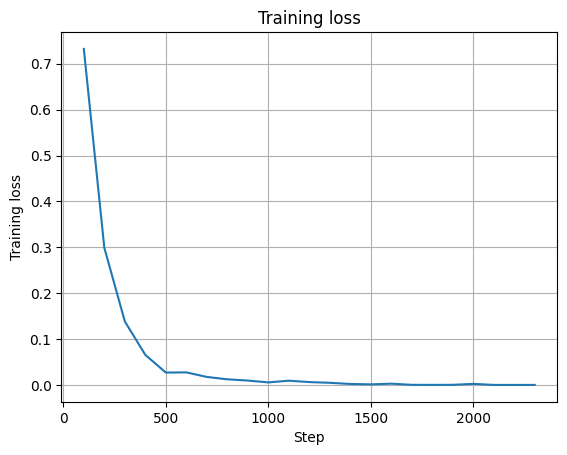

In [61]:
# Full fine-tuning on DistilBERT (3-class sentiment)

import os, numpy as np, evaluate
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from transformers import (
    AutoTokenizer, DataCollatorWithPadding,
    AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
)

# 1) tokenize
CHECKPOINT = "distilbert-base-uncased"
tok = AutoTokenizer.from_pretrained(CHECKPOINT, use_fast=True)

def tok_fn(b):  # truncate for safety
    return tok(b["sentence"], truncation=True, max_length=128)

tds_train = ds_train.map(tok_fn, batched=True)
tds_valid = ds_valid.map(tok_fn, batched=True)
tds_test  = ds_test .map(tok_fn, batched=True)

keep = ["input_ids","attention_mask","label"]
tds_train = tds_train.remove_columns([c for c in tds_train.column_names if c not in keep])
tds_valid = tds_valid.remove_columns([c for c in tds_valid.column_names if c not in keep])
tds_test  = tds_test .remove_columns([c for c in tds_test .column_names  if c not in keep])

collator = DataCollatorWithPadding(tok)

# 2) metrics
acc = evaluate.load("accuracy"); f1 = evaluate.load("f1")
def metrics(p):
    preds = np.argmax(p.predictions, axis=-1)
    return {
        "accuracy": acc.compute(predictions=preds, references=p.label_ids)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=p.label_ids, average="macro")["f1"],
    }

# 3) model
model = AutoModelForSequenceClassification.from_pretrained(
    CHECKPOINT, num_labels=3
)

# 4) training args (full FT is heavier; keep batch modest)
args = TrainingArguments(
    output_dir="runs/fpb_full_ft",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.05,
    fp16=True,                    # set True on CUDA
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_steps=100,
    report_to="none",
    seed=42,
    greater_is_better=True
    # lr_scheduler_type="cosine"
)

trainer = Trainer(
    model=model, args=args,
    train_dataset=tds_train, eval_dataset=tds_valid,
    tokenizer=tok, data_collator=collator,
    compute_metrics=metrics
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # simple early stop
)

trainer.train()

print("VALID =>", trainer.evaluate())          # best on valid
print("TEST  =>", trainer.evaluate(tds_test))  # final test

logs = trainer.state.log_history  # list[dict]
df = pd.DataFrame(logs)

train_df = df[df["loss"].notna()][["step","loss"]]

plt.figure()
plt.plot(train_df["step"], train_df["loss"])           # raw curve
plt.xlabel("Step"); plt.ylabel("Training loss"); plt.title("Training loss")
plt.grid(True)
plt.show()

Classification report (test):
              precision    recall  f1-score   support

    negative     0.9333    0.9333    0.9333        30
     neutral     0.9927    0.9784    0.9855       139
    positive     0.9153    0.9474    0.9310        57

    accuracy                         0.9646       226
   macro avg     0.9471    0.9530    0.9500       226
weighted avg     0.9653    0.9646    0.9648       226



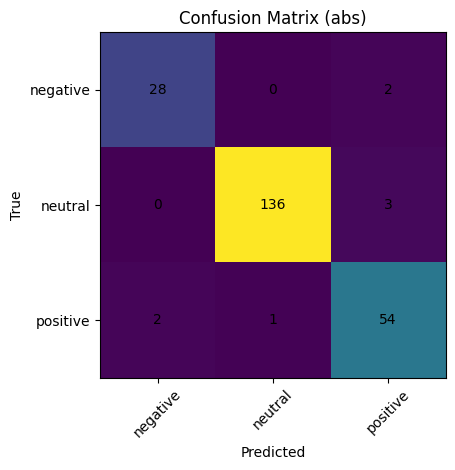

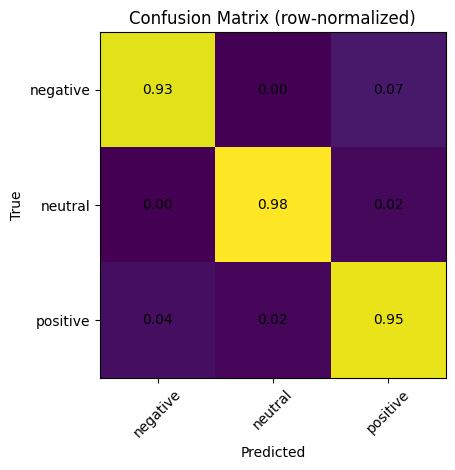


Top-10 confident mistakes:
       true      pred      conf    margin  \
7  positive   neutral  0.994192  0.990211   
0  positive  negative  0.990126  0.984514   
2  negative  positive  0.989578  0.983435   
6  negative  positive  0.988531  0.980258   
4  positive  negative  0.975797  0.954717   
3   neutral  positive  0.966162  0.940238   
5   neutral  positive  0.893263  0.797171   
1   neutral  positive  0.676945  0.366107   

                                            sentence  
7  These financing arrangements will enable the c...  
0  Unit costs for flight operations fell by 6.4 p...  
2  ADP News - Apr 22 , 2009 - Finnish business in...  
6  Finnish power supply solutions and systems pro...  
4  These moderate but significant changes resulte...  
3  Shuweihat 2 got under way in July 2008 when th...  
5  `` These developments partly reflect the gover...  
1  `` Each year , personal entertainment plays a ...  

Saved: errors_full_ft.csv
Saved model to runs/fpb_full_ft/best_model
[

In [62]:
# ===== 1) Test metrics =====

id2lab = {0:"negative", 1:"neutral", 2:"positive"}

# get predictions on test
pred = trainer.predict(tds_test)  # returns (predictions, label_ids, metrics)
logits = pred.predictions
y_true = pred.label_ids
y_pred = logits.argmax(axis=-1)

# macro metrics (already printed by trainer.evaluate, but we show per-class too)
print("Classification report (test):")
print(classification_report(y_true, y_pred, target_names=[id2lab[i] for i in [0,1,2]], digits=4))

# ===== 2) Confusion matrix (absolute + normalized) =====
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (abs)")
plt.xticks([0,1,2], [id2lab[i] for i in [0,1,2]], rotation=45)
plt.yticks([0,1,2], [id2lab[i] for i in [0,1,2]])
for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

plt.figure()
plt.imshow(cm_norm, interpolation='nearest')
plt.title("Confusion Matrix (row-normalized)")
plt.xticks([0,1,2], [id2lab[i] for i in [0,1,2]], rotation=45)
plt.yticks([0,1,2], [id2lab[i] for i in [0,1,2]])
for i in range(3):
    for j in range(3):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# ===== 3) Error analysis: hard mistakes =====
# softmax for confidence
probs = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()
conf = probs.max(axis=1)
margin = np.partition(probs, -2, axis=1)[:, -1] - np.partition(probs, -2, axis=1)[:, -2]  # top1 - top2

# rebuild raw sentences (need original order)
raw_sentences = ds_test["sentence"]  # HF Dataset before tokenization

errors = []
for i, (yt, yp) in enumerate(zip(y_true, y_pred)):
    if yt != yp:
        errors.append({
            "sentence": raw_sentences[i],
            "true": id2lab[yt],
            "pred": id2lab[yp],
            "conf": float(conf[i]),
            "margin": float(margin[i])
        })

err_df = pd.DataFrame(errors).sort_values(["conf","margin"], ascending=[False, False])
print("\nTop-10 confident mistakes:")
print(err_df.head(10)[["true","pred","conf","margin","sentence"]])

# save all mistakes for the report
err_df.to_csv("errors_full_ft.csv", index=False)
print("\nSaved: errors_full_ft.csv")

# ===== 4) Save the best model for inference =====
# (best already loaded because load_best_model_at_end=True)
trainer.save_model("runs/fpb_full_ft/best_model")
tok.save_pretrained("runs/fpb_full_ft/best_model")
print("Saved model to runs/fpb_full_ft/best_model")

# ===== 5) Tiny inference helper =====
def predict_sentences(sent_list):
    inputs = tok(sent_list, truncation=True, padding=True, return_tensors="pt").to(trainer.model.device)
    with torch.no_grad():
        out = trainer.model(**inputs).logits
        pr = torch.softmax(out, dim=-1).cpu().numpy()
    pred_ids = pr.argmax(axis=1)
    return [{"text": s, "pred": id2lab[i], "conf": float(pr[j, i])} 
            for j, (s, i) in enumerate(zip(sent_list, pred_ids))]

print(predict_sentences([
    "The company reported strong quarterly earnings.",
    "Revenue guidance was cut due to weak demand."
]))

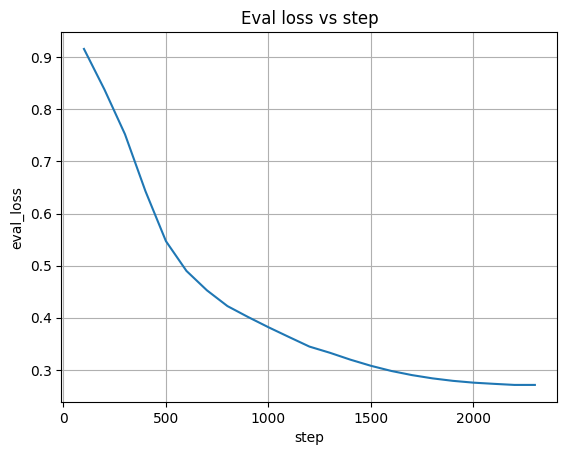

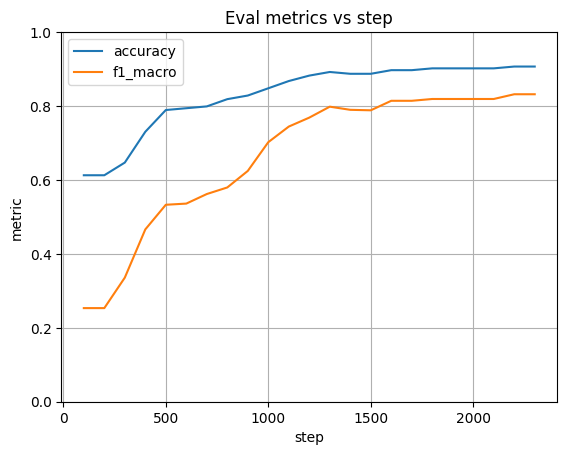

In [63]:
import pandas as pd, matplotlib.pyplot as plt

TR = trainer_lora if "trainer_lora" in globals() else trainer
log = pd.DataFrame(TR.state.log_history)
eval_cols = [c for c in log.columns if c.startswith("eval_")]
df = log.dropna(subset=eval_cols).groupby("step", as_index=False).last()

if "eval_loss" in df:
    
    plt.figure(); plt.plot(df["step"], df["eval_loss"])
    plt.xlabel("step"); plt.ylabel("eval_loss"); plt.title("Eval loss vs step"); plt.grid(True); plt.show()

skip = {"eval_loss","eval_runtime","eval_samples_per_second","eval_steps_per_second",
        "eval_mem_cpu_alloc_delta","eval_mem_gpu_alloc_delta"}
metrics = [m for m in eval_cols if m not in skip]

if metrics:
    plt.figure()
    plt.ylim(0,1)
    for m in metrics: plt.plot(df["step"], df[m], label=m[5:])
    plt.xlabel("step"); plt.ylabel("metric"); plt.title("Eval metrics vs step"); plt.legend(); plt.grid(True); plt.show()

In [69]:

CHECKPOINT = "distilbert-base-uncased"
tok = AutoTokenizer.from_pretrained(CHECKPOINT, use_fast=True)
def tok_fn(b): return tok(b["sentence"], truncation=True, max_length=128)

tds_train = ds_train.map(tok_fn, batched=True)
tds_valid = ds_valid.map(tok_fn, batched=True)
tds_test  = ds_test .map(tok_fn, batched=True)
keep = ["input_ids","attention_mask","label"]
tds_train = tds_train.remove_columns([c for c in tds_train.column_names if c not in keep])
tds_valid = tds_valid.remove_columns([c for c in tds_valid.column_names if c not in keep])
tds_test  = tds_test .remove_columns([c for c in tds_test .column_names  if c not in keep])

collator = DataCollatorWithPadding(tok)
acc = evaluate.load("accuracy"); f1 = evaluate.load("f1")
def metrics(p):
    preds = np.argmax(p.predictions, axis=-1)
    return {"accuracy": acc.compute(predictions=preds, references=p.label_ids)["accuracy"],
            "f1_macro": f1.compute(predictions=preds, references=p.label_ids, average="macro")["f1"]}

model_lora = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=3)
lcfg = LoraConfig(task_type=TaskType.SEQ_CLS, r=8, lora_alpha=16, lora_dropout=0.05,
                  target_modules=["q_lin","v_lin"])
model_lora = get_peft_model(model_lora, lcfg)

args_lora = TrainingArguments(
    output_dir="runs/fpb_lora2",
    eval_strategy="steps",     
    eval_steps=100,                  
    save_strategy="steps",            
    save_steps=100,                  
    save_total_limit=2,

    load_best_model_at_end=True, 
    metric_for_best_model="f1_macro", 
    greater_is_better=True,
    learning_rate=1e-5,
    per_device_train_batch_size=16, 
    per_device_eval_batch_size=32,
    num_train_epochs=20, 
    weight_decay=0.0, 
    fp16=torch.cuda.is_available(),

    logging_strategy="steps",
    logging_steps=100,

    report_to="none", seed=42
)

trainer_lora = Trainer(
    model=model_lora, args=args_lora,
    train_dataset=tds_train, eval_dataset=tds_valid,
    tokenizer=tok, data_collator=collator,
    compute_metrics=metrics,
)
trainer_lora.train()


Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Map:   0%|          | 0/204 [00:00<?, ? examples/s]

Map:   0%|          | 0/226 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_230/2653770050.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be u

Step,Training Loss,Validation Loss,Accuracy,F1 Macro
100,1.022800,0.924348,0.612745,0.253293
200,0.889800,0.840113,0.612745,0.253293
300,0.807800,0.759575,0.617647,0.266644
400,0.711000,0.652249,0.715686,0.447250
500,0.628200,0.547032,0.789216,0.531203
600,0.532900,0.485217,0.799020,0.541407
700,0.504900,0.446593,0.813725,0.573440
800,0.475300,0.416719,0.818627,0.578320
900,0.444300,0.395397,0.823529,0.602245
1000,0.419000,0.375025,0.848039,0.687849


TrainOutput(global_step=2300, training_loss=0.47669987471207326, metrics={'train_runtime': 115.663, 'train_samples_per_second': 316.264, 'train_steps_per_second': 19.885, 'total_flos': 562090671517428.0, 'train_loss': 0.47669987471207326, 'epoch': 20.0})

In [65]:
def count_params(m):
    tot = sum(p.numel() for p in m.parameters())
    trn = sum(p.numel() for p in m.parameters() if p.requires_grad)
    return tot, trn, 100*trn/tot

rows = []

# full-FT trainer's variance name may be trainer or trainer_full
if "trainer_full" in globals():
    TR_FULL = trainer_full
elif "trainer" in globals():
    TR_FULL = trainer
else:
    TR_FULL = None

if TR_FULL:
    m = TR_FULL.evaluate(tds_test)
    tot,trn,pct = count_params(TR_FULL.model)
    rows.append({"run":"full", "acc":m.get("eval_accuracy"), "f1":m.get("eval_f1_macro"),
                 "trainable_%":round(pct,2)})

m = trainer_lora.evaluate(tds_test)
tot,trn,pct = count_params(trainer_lora.model)
rows.append({"run":"lora", "acc":m.get("eval_accuracy"), "f1":m.get("eval_f1_macro"),
             "trainable_%":round(pct,2)})

df_cmp = pd.DataFrame(rows)
print(df_cmp)
df_cmp.to_csv("cmp_full_vs_lora.csv", index=False)

    run       acc        f1  trainable_%
0  full  0.964602  0.949958       100.00
1  lora  0.836283  0.762240         1.09


In [66]:
pred = trainer_lora.predict(tds_test)
y_true = pred.label_ids
y_pred = pred.predictions.argmax(axis=-1)
print(classification_report(y_true, y_pred, target_names=["neg","neu","pos"], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
pd.DataFrame(cm, index=["T_neg","T_neu","T_pos"], columns=["P_neg","P_neu","P_pos"]).to_csv("cm_lora.csv")

# top mistakes
probs = torch.softmax(torch.from_numpy(pred.predictions), dim=-1).numpy()
conf = probs.max(axis=1)
err = []
for i,(t,p) in enumerate(zip(y_true,y_pred)):
    if t!=p:
        err.append({"true":t,"pred":p,"conf":float(conf[i]),"sentence":ds_test[i]["sentence"]})
pd.DataFrame(sorted(err,key=lambda x:-x["conf"]))[:20].to_csv("errors_lora_top20.csv", index=False)

              precision    recall  f1-score   support

         neg     0.7308    0.6333    0.6786        30
         neu     0.9103    0.9496    0.9296       139
         pos     0.6909    0.6667    0.6786        57

    accuracy                         0.8363       226
   macro avg     0.7773    0.7499    0.7622       226
weighted avg     0.8312    0.8363    0.8330       226



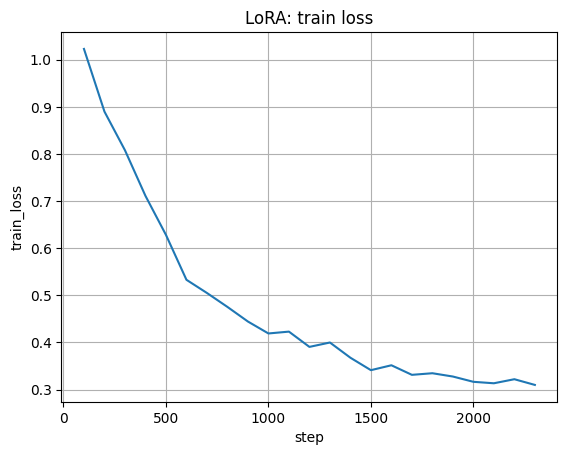

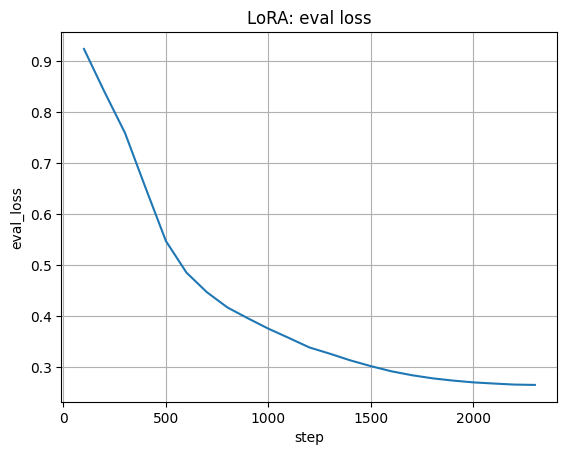

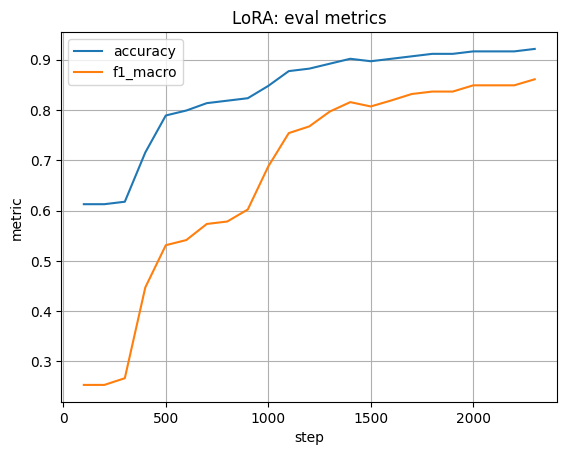

In [70]:
log = pd.DataFrame(trainer_lora.state.log_history)

# train curve
train_log = log.dropna(subset=["loss"])
plt.figure(); plt.plot(train_log["step"], train_log["loss"])
plt.xlabel("step"); plt.ylabel("train_loss"); plt.title("LoRA: train loss"); plt.grid(True)
plt.savefig("lora_train_loss.png", dpi=200, bbox_inches="tight"); plt.show()

# evaluate curve (step)
eval_log = log.dropna(subset=["eval_loss"])
plt.figure(); plt.plot(eval_log["step"], eval_log["eval_loss"])
plt.xlabel("step"); plt.ylabel("eval_loss"); plt.title("LoRA: eval loss"); plt.grid(True)
plt.savefig("lora_eval_loss.png", dpi=200, bbox_inches="tight"); plt.show()

# evaluate target(step)
plt.figure()
if "eval_accuracy" in eval_log: plt.plot(eval_log["step"], eval_log["eval_accuracy"], label="accuracy")
if "eval_f1_macro" in eval_log: plt.plot(eval_log["step"], eval_log["eval_f1_macro"], label="f1_macro")
plt.xlabel("step"); plt.ylabel("metric"); plt.title("LoRA: eval metrics"); plt.legend(); plt.grid(True)
plt.savefig("lora_eval_metrics.png", dpi=200, bbox_inches="tight"); plt.show()